# LangGraph.js - Quickstart

## Introduction

In this quickstart guide, you'll get up and running with a simple Reason + Act Agent (often
called a ReAct Agent) that can search the web using [Tavily Search API](https://tavily.com/).
The code is fully configurable. You can:

- swap out components
- customize the execution flow
- extend it with custom code or tooling
- change the Large Language Model (LLM) and provider being used


## Prerequisites

To follow along, you'll need to have the following:

- NodeJS version 18 or newer
- A [Tavily](https://tavily.com/) account and API key
- An [OpenAI developer platform](https://platform.openai.com/docs/overview) account and API key

Start by creating a new folder for the project. Open your terminal and run the following code:

```bash
mkdir langgraph-agent
cd langgraph-agent
```

You'll also need to install a few dependencies to create an agent:

- **`@langchain/langgraph`** contains the building blocks used to assemble an agent
- **`@langchain/openai`** enable your agent to use OpenAI's LLMs
- **`@langchain/community`** includes the Tavily integration give your agent search capabilities

You can install these dependencies using by running following npm command in your terminal:

```bash
npm install @langchain/core @langchain/langgraph @langchain/openai @langchain/community
```

## LangSmith

Optionally, set up [LangSmith](https://docs.smith.langchain.com/) for best-in-class observability. Setup is simple - add the following variables to your environment and update the `LANGCHAIN_API_KEY` value with your API key.

In [1]:
// Optional, add tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "ls__...";
// process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
// process.env.LANGCHAIN_TRACING_V2 = "true";
// process.env.LANGCHAIN_PROJECT = "Quickstart: LangGraphJS";


## Making your first agent using LangGraph

Create a file named `agent.mts` (short for Reason + Act Agent) and add the below TypeScript code to it.

Make sure you update the environment variables at the top of the file to contain your API keys. If you don't, the OpenAI and Tavily API calls will produce errors and your agent will not work correctly.

Once you've added your API keys, save the file and run the code with the following command:

```bash
npx tsx agent.mts
```

In [ ]:
// agent.mts

// IMPORTANT - Add your API keys here. Be careful not to publish them.
process.env.OPENAI_API_KEY = "sk-...";
process.env.TAVILY_API_KEY = "tvly-...";

import { TavilySearch } from "@langchain/tavily";
import { ChatOpenAI } from "@langchain/openai";
import { MemorySaver } from "@langchain/langgraph";
import { HumanMessage } from "@langchain/core/messages";
import { createReactAgent } from "@langchain/langgraph/prebuilt";

// Define the tools for the agent to use
const agentTools = [new TavilySearch({ maxResults: 3 })];
const agentModel = new ChatOpenAI({ temperature: 0 });

// Initialize memory to persist state between graph runs
const agentCheckpointer = new MemorySaver();
const agent = createReactAgent({
  llm: agentModel,
  tools: agentTools,
  checkpointSaver: agentCheckpointer,
});

// Now it's time to use!
const agentFinalState = await agent.invoke(
  { messages: [new HumanMessage("what is the current weather in sf")] },
  { configurable: { thread_id: "42" } },
);

console.log(
  agentFinalState.messages[agentFinalState.messages.length - 1].content,
);

const agentNextState = await agent.invoke(
  { messages: [new HumanMessage("what about ny")] },
  { configurable: { thread_id: "42" } },
);

console.log(
  agentNextState.messages[agentNextState.messages.length - 1].content,
);

The current weather in San Francisco is as follows:
- Temperature: 82.0°F (27.8°C)
- Condition: Sunny
- Wind: 11.9 mph from the NW
- Humidity: 41%
- Pressure: 29.98 in
- Visibility: 9.0 miles
- UV Index: 6.0

For more details, you can visit [Weather in San Francisco](https://www.weatherapi.com/).
The current weather in New York is as follows:
- Temperature: 84.0°F (28.9°C)
- Condition: Sunny
- Wind: 2.2 mph from SSE
- Humidity: 57%
- Pressure: 29.89 in
- Precipitation: 0.01 in
- Visibility: 9.0 miles
- UV Index: 6.0

For more details, you can visit [Weather in New York](https://www.weatherapi.com/).


## How does it work?

The
[createReactAgent](/langgraphjs/reference/functions/langgraph_prebuilt.createReactAgent.html)
constructor lets you create a simple tool-using LangGraph agent in a single line
of code. Here's a visual representation of the graph:

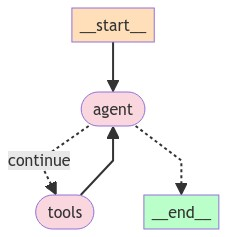

In [2]:
// Note: tslab only works inside a jupyter notebook. Don't worry about running this code yourself!
import * as tslab from "tslab";

const graph = agent.getGraph();
const image = await graph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

Alternatively, you can save the graph as a PNG file locally using the following approach:

```ts
import { writeFileSync } from "node:fs";

const graphStateImage = await drawableGraphGraphState.drawMermaidPng();
const graphStateArrayBuffer = await graphStateImage.arrayBuffer();

const filePath = "./graphState.png";
writeFileSync(filePath, new Uint8Array(graphStateArrayBuffer));
```


## Customizing agent behavior

createReactAgent can be great for simple agents, but sometimes you need something more powerful.

LangGraph really shines when you need fine-grained control over an agent's behavior. The following
code creates an agent with the same behavior as the example above, but you can
clearly see the execution logic and how you could customize it.

Update the code in your `agent.mts` file to match the example below. Once again, be sure to update
the environment variables at the top.

After you've updated your environment variables and saved the file, you can run it with the same command as before:

```bash
npx tsx agent.mts
```

In [ ]:
// agent.mts

// IMPORTANT - Add your API keys here. Be careful not to publish them.
process.env.OPENAI_API_KEY = "sk-...";
process.env.TAVILY_API_KEY = "tvly-...";

import { TavilySearch } from "@langchain/tavily";
import { ChatOpenAI } from "@langchain/openai";
import { HumanMessage, AIMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { StateGraph, MessagesAnnotation } from "@langchain/langgraph";

// Define the tools for the agent to use
const agentTools = [new TavilySearch({ maxResults: 3 })];
const toolNode = new ToolNode(tools);

// Create a model and give it access to the tools
const model = new ChatOpenAI({
  model: "gpt-4o-mini",
  temperature: 0,
}).bindTools(tools);

// Define the function that determines whether to continue or not
function shouldContinue({ messages }: typeof MessagesAnnotation.State) {
  const lastMessage = messages[messages.length - 1] as AIMessage;

  // If the LLM makes a tool call, then we route to the "tools" node
  if (lastMessage.tool_calls?.length) {
    return "tools";
  }
  // Otherwise, we stop (reply to the user) using the special "__end__" node
  return "__end__";
}

// Define the function that calls the model
async function callModel(state: typeof MessagesAnnotation.State) {
  const response = await model.invoke(state.messages);

  // We return a list, because this will get added to the existing list
  return { messages: [response] };
}

// Define a new graph
const workflow = new StateGraph(MessagesAnnotation)
  .addNode("agent", callModel)
  .addEdge("__start__", "agent") // __start__ is a special name for the entrypoint
  .addNode("tools", toolNode)
  .addEdge("tools", "agent")
  .addConditionalEdges("agent", shouldContinue);

// Finally, we compile it into a LangChain Runnable.
const app = workflow.compile();

// Use the agent
const finalState = await app.invoke({
  messages: [new HumanMessage("what is the weather in sf")],
});
console.log(finalState.messages[finalState.messages.length - 1].content);

const nextState = await app.invoke({
  // Including the messages from the previous run gives the LLM context.
  // This way it knows we're asking about the weather in NY
  messages: [...finalState.messages, new HumanMessage("what about ny")],
});
console.log(nextState.messages[nextState.messages.length - 1].content);

There are a few new things going on in this version of our ReAct Agent.

A [`ToolNode`](https://langchain-ai.github.io/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html) enables the LLM to use tools.
In this example, we made a `shouldContinue` function and passed it to [`addConditionalEdge`](https://langchain-ai.github.io/langgraphjs/reference/classes/langgraph.StateGraph.html#addConditionalEdges) so our ReAct Agent can either call a tool or respond to the request.

[Annotations](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#annotation) are how graph state is represented in LangGraph. We're using [`MessagesAnnotation`](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#messagesannotation), a helper that implements a common pattern: keeping the message history in an array.

## Next Steps

Great job creating your first AI agent using LangGraph! If you're ready to build
something more, check out our other [tutorials](/langgraphjs/tutorials/)
to learn how to implement other end-to-end agentic workflows such as:

- [Retrieval-Augmented Generation (RAG)](/langgraphjs/tutorials/rag/langgraph_agentic_rag/)
- [Multi-agent collaboration](/langgraphjs/tutorials/multi_agent/multi_agent_collaboration/)
- [Reflection](/langgraphjs/tutorials/reflection/reflection/), where the agent evaluates its work

If you'd rather improve your agent we have [how-to guides](/langgraphjs/how-tos/) to help, including:

- [Tool calling](/langgraphjs/how-tos/tool-calling/) that enables agents to interact with APIs
- give your agent [persistent memory](/langgraphjs/how-tos/persistence/) to continue conversations and debug unexpected behavior
- Put a [human in the loop](/langgraphjs/how-tos/breakpoints/) for actions you want a human to verify
- [Streaming the agent output](/langgraphjs/how-tos/stream-values/) to make your application feel more responsive
- [Change the AI model in one line of code](https://js.langchain.com/docs/how_to/chat_models_universal_init/)
